# Benchmarks of already working functions - Numcosmo Learning

First of all, let us import some useful packages.

In [1]:
######## GENERAL ########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
######## NUM COSMO ########
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [3]:
######## CCL ########
#import pyccl as ccl

Now, let us initialize the NumCosmo library.

In [4]:
#  Initializing the library objects, this must be called before 
#  any other library function.
#
Ncm.cfg_init ()

### Defining the cosmological parameters

In [5]:
Omega_c = 0.25   # The cold dark matter density fraction.

Omega_b = 0.05   # The baryonic matter density fraction.

Omega_k = 0.0    # The curvature density fraction.
        
h       = 0.7    # The hubble constant divided by 100 km/s/Mpc; unitless.

A_s     = 2.1e-9 # The power spectrum normalization.

n_s     = 0.96   # The primordial scalar perturbation spectral index.

Neff    = 3.046  # The effective number of massless neutrinos present.

w0 = -1.0        # The first order term of dark energy equation of state.

wa = 0.0         # The second order term of dark energy equation of state.

### Defining the cosmological model

Here, I define the cosmological model, accordingly to the parameters above.

In [6]:
########################################################################
### NcHICosmo — Abstract class for implementing homogeneous and isotropic cosmological models
### NcHICosmoDECpl — Dark Energy -- Chevallier–Polarski–Linder equation of state
### nc_hicosmo_new_from_name (GType parent_type, gchar *cosmo_name): Creates a new instance of "cosmo_name", 
#                                                                    asserting that it descends from "parent_type".
nc_cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")

### Source: https://numcosmo.github.io/manual/NcHICosmo.html#nc-hicosmo-new-from-name
### Source: https://numcosmo.github.io/manual/NcHICosmoDECpl.html (Theory)

### massnu-length: this depends on how many neutrinos types we are considering to be massive or massless.
########################################################################



########################################################################
nc_cosmo.omega_x2omega_k ()

### This line is for us to work with Omega_k as a parameter instead of Omega_x (dark energy). If we don't have this
### line, we will automatically be working with Omega_x.
########################################################################



########################################################################
nc_cosmo.param_set_by_name ("Omegac",    Omega_c)
nc_cosmo.param_set_by_name ("Omegab",    Omega_b)
#nc_cosmo.param_set_by_name ("Omegax",       0.70)
nc_cosmo.param_set_by_name ("Omegak",    Omega_k)
nc_cosmo.param_set_by_name ("H0",        h * 100)
nc_cosmo.param_set_by_name ("ENnu",      Neff)
nc_cosmo.param_set_by_name ("w0",        w0)
nc_cosmo.param_set_by_name ("w1",        wa)

########################################################################


Now, I will define the function to perform distance calculations.

In [7]:
########################################################################
### NcDistance — Cosmological distance and time related quantities.
### nc_distance_new (gdouble zf): Creates a new NcDistance object optimized to perform
#                                 distance calculations to redshift up to zf.
dist = Nc.Distance.new (5.0)

### Source: https://numcosmo.github.io/manual/NcDistance.html (Theory)
### Source: https://numcosmo.github.io/manual/NcDistance.html#nc-distance-new
########################################################################



########################################################################
### nc_distance_prepare (NcDistance *dist, NcHICosmo *cosmo):This function prepares the object "dist" using "cosmo",
#                                                            such that all the available distances functions can be
#                                                            evaluated, e.g. nc_distance_comoving().
dist.prepare (nc_cosmo)

### Source: https://numcosmo.github.io/manual/NcDistance.html#nc-distance-prepare
########################################################################

Here, I will define the Transfer Function and the Power Spectrum to be used.

In [8]:
########################################################################
### THIS IS NECESSARY FOR Nc.PowspecMLTransfer.
### NcHIPrim — Abstract class for implementing homogeneous and isotropic primordial cosmological models.
### NcHIPrimPowerLaw — Power law implementation for primordial spectra.

hiprim = Nc.HIPrimPowerLaw.new ()
hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
hiprim.param_set_by_name ("n_SA",       n_s)
    
nc_cosmo.add_submodel (hiprim)

### Source: https://numcosmo.github.io/manual/NcHIPrimPowerLaw.html (Theory)

In [9]:
########################################################################
### NcTransferFunc — Abstrac class for perturbation transfer function.
### NcTransferFuncEH — Eisenstein-Hu fitting function for the transfer function.
### nc_transfer_func_eh_new (void): Creates a new NcTransferFunc of the NcTransferFuncEH type.

tf_eh = Nc.TransferFuncEH.new ()

### Source: https://numcosmo.github.io/manual/NcTransferFuncEH.html (Theory)
########################################################################

########################################################################
#tf_eh.props.CCL_comp = True

##### DÚVIDA 1 ####
### Eu esqueci se aqui tem a ver com comparação, compatibilidade ou conta (computation).
########################################################################
########################################################################

In [10]:
########################################################################
### NcPowspecML — Abstract class for linear matter power spectrum implementation.
### NcPowspecMLTransfer — Class for linear matter power spectrum from a transfer function.
### nc_powspec_ml_transfer_new (NcTransferFunc *tf):Creates a new NcPowspecMLTransfer from the transfer function tf .

ps_eh = Nc.PowspecMLTransfer.new (tf_eh)

### Source: https://numcosmo.github.io/manual/NcPowspecMLTransfer.html (Theory)
########################################################################

In [11]:
########################################################################
ps_eh.prepare (nc_cosmo)
########################################################################

### Trying to define the kernel and run the cross correlation computation

In [12]:
########################################################################
#NcmMSet — A set of different NcmModel objects.
#NcmModel — Abstract class for implementing models.
mset = Ncm.MSet.empty_new ()
mset.set (nc_cosmo)

# No mset, "guardamos" um conjunto de modelos para cálculos posteriores.
########################################################################



########################################################################
# Ell-dependent correction factors
# Set up array of ells
lmax = 10000
ells = np.arange(lmax+1)

### O que estava antes:
#nls = (lmax - 400) // 20 + 141
#ells = np.zeros(nls)
#ells[:101] = np.arange(101)
#ells[101:121] = ells[100] + (np.arange(20) + 1) * 5
#ells[121:141] = ells[120] + (np.arange(20) + 1) * 10
#ells[141:] = ells[140] + (np.arange(nls - 141) + 1) * 20

##### DÚVIDA 2 ####
#Qual a motivação para fazer isso aqui? Em qual equação esses fatores de correção aparecem? Por que o "nls"
#é definido da forma acima?
########################################################################



########################################################################

# Histogram case
z1 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
pz1 = [0.03042845,0.03414402,0.03799253,0.04299767,0.05033486,0.06090954,0.07214195,0.08122409,0.09440498,0.1069006,0.1193231,0.1345755,0.1574345,0.1814089,0.2129027,0.2362395,0.2668045,0.3002025,0.3352957,0.3745351,0.4194854,0.4623063,0.5050753,0.5454309,0.5963121,0.6618579,0.7288298,0.8091178,0.898688,0.9962031,1.104119,1.216311,1.32999,1.435197,1.512844,1.58501,1.652862,1.703158,1.741018,1.772948,1.774767,1.763834,1.737957,1.726589,1.737972,1.753971,1.763453,1.802562,1.856402,1.900287,1.9703,2.067721,2.174633,2.281516,2.373034,2.444509,2.524466,2.565968,2.591811,2.636548,2.668677,2.667052,2.662519,2.650229,2.636122,2.642808,2.631578,2.617414,2.585296,2.516713,2.433994,2.371482,2.312537,2.243322,2.161209,2.053728,1.949206,1.849159,1.756659,1.680961,1.607236,1.512338,1.403549,1.296255,1.194675,1.099351,1.006349,0.9175507,0.8346777,0.7518989,0.6750844,0.6090778,0.5471522,0.4921195,0.4383578,0.3932878,0.3505944,0.3069157,0.2660076,0.2260665,0.1912351,0.1602497,0.1342543,0.1105429,0.09371526,0.07828563,0.06450086,0.05691218,0.05188841,0.04927132,0.04626028,0.04556604,0.04560567,0.04429971,0.04462289,0.04330885,0.04531251,0.04556658,0.04682577,0.04804921,0.05014561,0.05017483,0.04971365,0.0498952,0.05009804,0.05045293,0.05051581,0.05173462,0.05239803,0.05211333,0.05046592,0.04824938,0.04685445,0.04832953,0.04773316,0.04719018,0.04581053,0.04330763,0.04180981,0.0409335,0.03975677,0.03999396,0.04020634,0.04043189,0.03879762,0.03973875,0.03834657,0.03841882,0.03693463,0.03597824,0.03656528,0.03627733,0.0368738,0.03706237,0.03943152,0.03926759,0.04037174,0.04044818,0.04122869,0.04159501,0.0407858,0.04100093,0.03983945,0.03702105,0.035423,0.03340422,0.03194788,0.0302819,0.02866295,0.0283969,0.02863473,0.02794187,0.02742471,0.02713259,0.02723712,0.02731734,0.02779379,0.02876089,0.02951878,0.0293301,0.02866049,0.02870192,0.02811025,0.02743557,0.0259726,0.02577944,0.02464586,0.02338112,0.0217144,0.02120506,0.02094031,0.01955321,0.01917961,0.01865226,0.01782826,0.01645653,0.01553533,0.01498327,0.01385961]

z2 = [0.51125,0.51875,0.52625,0.5337500000000001,0.54125,0.5487500000000001,0.55625,0.5637500000000001,0.57125,0.57875,0.58625,0.59375,0.6012500000000001,0.60875,0.6162500000000001,0.62375,0.63125,0.63875,0.64625,0.65375,0.66125,0.6687500000000001,0.67625,0.6837500000000001,0.69125,0.69875,0.70625,0.71375,0.7212500000000001,0.72875,0.7362500000000001,0.74375,0.7512500000000001,0.75875,0.76625,0.77375,0.78125,0.7887500000000001,0.79625,0.8037500000000001,0.81125,0.81875,0.82625,0.83375,0.84125,0.84875,0.8562500000000001,0.86375,0.8712500000000001,0.87875,0.88625,0.89375,0.90125,0.9087500000000001,0.91625,0.9237500000000001,0.93125,0.9387500000000001,0.94625,0.95375,0.96125,0.96875,0.9762500000000001,0.98375,0.9912500000000001,0.99875,1.0062499999999999,1.01375,1.02125,1.0287499999999998,1.03625,1.04375,1.05125,1.0587499999999999,1.06625,1.07375,1.0812499999999998,1.0887499999999999,1.09625,1.10375,1.1112499999999998,1.11875,1.12625,1.1337499999999998,1.1412499999999999,1.14875,1.15625,1.1637499999999998,1.17125,1.17875,1.18625,1.1937499999999999,1.20125,1.20875,1.2162499999999998,1.22375,1.23125,1.23875,1.2462499999999999,1.25375,1.26125,1.2687499999999998,1.2762499999999999,1.28375,1.29125,1.2987499999999998,1.30625,1.31375,1.3212499999999998,1.3287499999999999,1.33625,1.34375,1.3512499999999998,1.35875,1.36625,1.37375,1.3812499999999999,1.38875,1.39625,1.4037499999999998,1.41125,1.41875,1.42625,1.4337499999999999,1.44125,1.44875,1.4562499999999998,1.4637499999999999,1.47125,1.47875,1.4862499999999998,1.49375,1.50125,1.5087499999999998,1.5162499999999999,1.52375,1.53125,1.5387499999999998,1.54625,1.55375,1.56125,1.5687499999999999,1.57625,1.58375,1.5912499999999998,1.59875,1.60625,1.61375,1.6212499999999999,1.62875,1.63625,1.6437499999999998,1.6512499999999999,1.65875,1.66625,1.6737499999999998,1.68125,1.68875,1.6962499999999998,1.7037499999999999,1.71125,1.71875,1.7262499999999998,1.73375,1.74125,1.74875,1.7562499999999999,1.76375,1.77125,1.7787499999999998,1.78625,1.79375,1.80125,1.8087499999999999,1.81625,1.82375,1.8312499999999998,1.8387499999999999,1.84625,1.85375,1.8612499999999998,1.86875,1.87625,1.8837499999999998,1.8912499999999999,1.89875,1.90625,1.9137499999999998,1.92125,1.92875,1.93625,1.9437499999999999,1.95125,1.95875,1.9662499999999998,1.97375,1.98125,1.98875,1.9962499999999999]
pz2 = [0.02052227,0.02128476,0.02239694,0.02465136,0.02586701,0.03179429,0.03392884,0.0367469,0.04154996,0.04243694,0.04518474,0.04727245,0.05213725,0.06062088,0.06824402,0.07278402,0.08242115,0.09059329,0.09545925,0.1037852,0.1127547,0.1194203,0.1214864,0.1178928,0.1201941,0.1196488,0.1201862,0.1167615,0.1193688,0.1208544,0.1229058,0.1242607,0.1239687,0.1270272,0.1243528,0.1200976,0.1130248,0.1113359,0.1040341,0.09660113,0.08767327,0.08330837,0.07821314,0.07217775,0.06684813,0.06545177,0.06539616,0.06688858,0.06832995,0.06796344,0.07096691,0.07170753,0.07706039,0.08479357,0.09471338,0.1036854,0.1107307,0.1190918,0.1282902,0.1383972,0.1526025,0.1626396,0.1764611,0.1898772,0.1983843,0.2129817,0.2242674,0.2358476,0.2481126,0.2667389,0.2783668,0.3034779,0.3362693,0.3685216,0.4165157,0.4673775,0.521112,0.5931014,0.6609077,0.7264559,0.7962301,0.8749996,0.9607969,1.056802,1.156963,1.256299,1.378734,1.510344,1.672523,1.851898,2.039046,2.210871,2.363395,2.487797,2.587954,2.669776,2.745778,2.766685,2.737778,2.669233,2.582152,2.480724,2.370255,2.269433,2.185606,2.102805,1.983777,1.888873,1.804964,1.731546,1.668124,1.623094,1.573137,1.527214,1.473416,1.422128,1.393125,1.351983,1.336813,1.346803,1.351484,1.340388,1.352429,1.367506,1.368783,1.370403,1.377519,1.385641,1.385694,1.353968,1.30617,1.262473,1.210346,1.161107,1.115958,1.081432,1.041388,1.007879,0.9826291,0.9673974,0.9631128,0.9654323,0.9540624,0.9355531,0.9179233,0.9064376,0.8738709,0.8401182,0.7926394,0.7452493,0.7113778,0.6816197,0.665836,0.6483249,0.6367261,0.6235866,0.6165185,0.6122504,0.6033517,0.5971109,0.5756226,0.54784,0.5118714,0.4759495,0.4347915,0.3872084,0.348376,0.3066147,0.2736164,0.2427426,0.22066,0.2012315,0.1880263,0.1787777,0.1752531,0.1687745,0.1658762,0.165598,0.1634433,0.1612935,0.1563185,0.1494878,0.1408261,0.1306753,0.1201645,0.1131836,0.1053328,0.09754543,0.08818486,0.07864627,0.07041585,0.06252,0.05618527,0.05119691,0.04662244,0.0394575,0.03291768,0.02839416,0.02382886]

z1 = np.array(z1)
z2 = np.array(z2)

### dn/dz is the (automatically normalized) redshift distribution of galaxies.
#   Source: https://numcosmo.github.io/manual/NcXcorLimberKernelGal.html.
#   Vamos fazer um spline com esses dados para obter dn/dz.

##### DÚVIDA 3 ####
### De onde vem esses dados??
########################################################################
########################################################################



########################################################################
### NcmVector *
#   ncm_vector_new_array (GArray *a);
#   This function saves "a" internally and frees it when it is no longer necessary. The "a" array must not be freed.

v_z1  = Ncm.Vector.new_array (z1)
v_pz1 = Ncm.Vector.new_array (pz1)
v_pz2 = Ncm.Vector.new_array (pz2)
########################################################################



########################################################################
### NcmSplineCubicNotaknot — Cubic spline implementation with 'not a knot' boundary conditions.
### NcmSpline *
#   ncm_spline_cubic_notaknot_new_full (NcmVector *xv,NcmVector *yv,gboolean init);
#   This function returns a new NcmSpline setting all its members.
### Parameters
#   xv: NcmVector of knots
#   yv: NcmVector of the values of the function, to be interpolated, computed at xv
#   init: TRUE to prepare the new NcmSpline or FALSE to not prepare it

s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)
s_pz2 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz2, True)
########################################################################



########################################################################
nc_g1 = None
nc_g2 = None
##### NcXcorLimberKernelGal *
#nc_xcor_limber_kernel_gal_new (gdouble zmin,
#                               gdouble zmax,
#                               gsize np,
#                               gdouble nbarm1,
#                               NcmSpline *dn_dz,
#                               NcDistance *dist,
#                               gboolean domagbias);
##### Parameters
#zmin: a gdouble.
#zmax: a gdouble.
#np: number of points in the interpolation.
#nbarm1: a gdouble, noise spectrum.
#dn_dz: a NcmSpline.
#dist: a NcDistance.
#domagbias: whether to do magnification bias.


nc_g1 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz1, dist, False)
nc_g2 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz2, dist, False)

##### DÚVIDA 5 ####
### zmin e zmax eu creio que seja o intervalo para que a interpolação seja feita no Kernel.
### Porque np = 1? 
### O que é "noise spectrum"? Quando isso seria usado?
### O dn_dz acho que está ok, tirando as dúvidas anteriores.
### dist também está ok.
### domagbias também está ok.
########################################################################



########################################################################
mset.push (nc_g1)
mset.push (nc_g2)

# Aqui, estamos "empurrando" os XcorLimberKernelGal no mset.
########################################################################



########################################################################
### NcXcor *
#   nc_xcor_new (NcDistance *dist, NcmPowspec *ps, NcXcorLimberMethod meth);
#   Two methods are available to compute Limber-approximated integrals: independent GSL numerical integration or 
# vector integration using Sundials's CVode algorithm.
xcor = Nc.Xcor.new (dist, ps_eh, Nc.XcorLimberMethod.GSL)
########################################################################



########################################################################
### NcmVector *
#   ncm_vector_new (gsize n);
#   This function allocates memory for a new NcmVector of doubles with n components.
vp_cross = Ncm.Vector.new (lmax + 1)
vp_auto1 = Ncm.Vector.new (lmax + 1)
vp_auto2 = Ncm.Vector.new (lmax + 1)
########################################################################



########################################################################
xcor.prepare (nc_cosmo)
########################################################################



########################################################################
### Reference: https://numcosmo.github.io/manual/NcXcor.html#nc-xcor-limber
if nc_g1 and nc_g2:
    nc_g1.prepare (nc_cosmo)
    nc_g2.prepare (nc_cosmo)
    xcor.limber (nc_g1, nc_g2, nc_cosmo, 0, lmax, vp_cross)
    xcor.limber (nc_g1, nc_g1, nc_cosmo, 0, lmax, vp_auto1)
    xcor.limber (nc_g2, nc_g2, nc_cosmo, 0, lmax, vp_auto2)
########################################################################

In [13]:
lista_cross = [Ncm.Vector.get (vp_cross, i) for i in np.arange(0,lmax+1)]
lista_auto1 = [Ncm.Vector.get (vp_auto1, i) for i in np.arange(0,lmax+1)]
lista_auto2 = [Ncm.Vector.get (vp_auto2, i) for i in np.arange(0,lmax+1)]

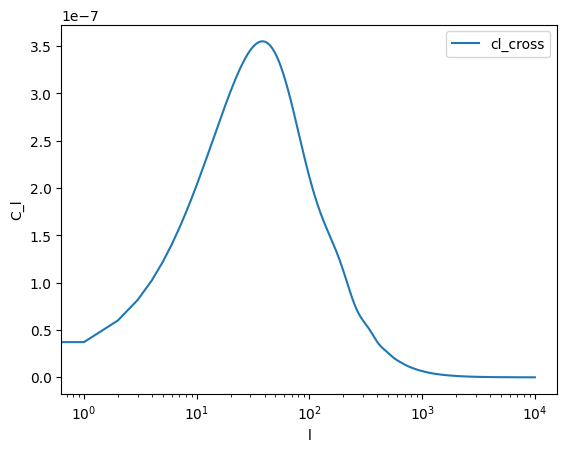

In [14]:
plt.plot(ells, lista_cross, label='cl_cross')
#plt.plot(ells, lista_auto1, label='cl_auto1' )
#plt.plot(ells, lista_auto2, label='cl_auto2' )
plt.legend()
plt.xscale('log')
plt.xlabel('l')
plt.ylabel('C_l')
plt.show()

In [15]:
### DÚVIDA
# Eu modifiquei o array dos "ells". Deixei ele como um simples np.arange(lmax+1), onde lmax=10000. 
# Mais para a frente, define-se vp = Ncm.Vector.new (lmax + 1). Depois, calcula-se a auto-correlação de 
# lmin=0 a lmax=lmax. O resultado dos Cls é guardado no vetor Vp. Até aí tudo bem. O problema é que, se eu chamo 
# Ncm.Vector.get (vp, 20000), ele me dá a resposta! Como assim? Não era para Vp estar definido só até lmax?
Ncm.Vector.get (vp_cross, 20000)

1.4899519074388405e-10

In [16]:
len_vp = Ncm.Vector.len (vp_cross)
variation = 3000
n_min = len_vp - variation
n_max = len_vp + variation
step = 50

print("Length of the vector: "+str(len_vp))
for i in np.arange(n_min,n_max,step):
    print("Element %i: " % i + str(Ncm.Vector.get (vp_cross, i)))

Length of the vector: 10001
Element 7001: 7.51200618570892e-11
Element 7051: 7.381020883332688e-11
Element 7101: 7.25317052626737e-11
Element 7151: 7.128359816917301e-11
Element 7201: 7.006496952742955e-11
Element 7251: 6.887493476210453e-11
Element 7301: 6.77126417252692e-11
Element 7351: 6.657726894513506e-11
Element 7401: 6.546802420387277e-11
Element 7451: 6.438414375150549e-11
Element 7501: 6.332489092371536e-11
Element 7551: 6.22895547492723e-11
Element 7601: 6.127744921633609e-11
Element 7651: 6.028791225521534e-11
Element 7701: 5.932030458046477e-11
Element 7751: 5.837400874688375e-11
Element 7801: 5.7448428453057384e-11
Element 7851: 5.654298772808867e-11
Element 7901: 5.565712981935322e-11
Element 7951: 5.4790316611438965e-11
Element 8001: 5.3942028076680164e-11
Element 8051: 5.3111761299987195e-11
Element 8101: 5.229902982329422e-11
Element 8151: 5.150336320896762e-11
Element 8201: 5.0724306290381985e-11
Element 8251: 4.9961418566611875e-11
Element 8301: 4.921427374961069e-1

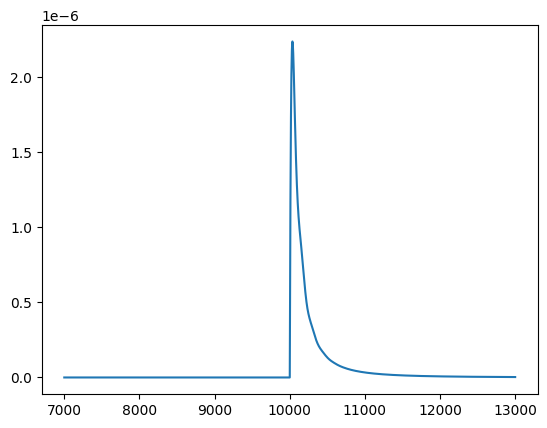

In [17]:
plt.plot(np.arange(n_min, n_max, 1), [Ncm.Vector.get (vp_cross, i) for i in np.arange(n_min, n_max, 1)])
plt.show()